In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

In [2]:
df = pd.read_csv("../data/cleaned_retail_data.csv")
df['Date'] = pd.to_datetime(df['Date'])

In [4]:
monthly_revenue = (
    df
    .set_index('Date')
    .resample('ME')['Revenue']
    .sum()
)

In [5]:
monthly_revenue.head()

Date
2023-03-31    2.152832e+07
2023-04-30    2.056744e+07
2023-05-31    2.105684e+07
2023-06-30    2.008197e+07
2023-07-31    2.122312e+07
Freq: ME, Name: Revenue, dtype: float64

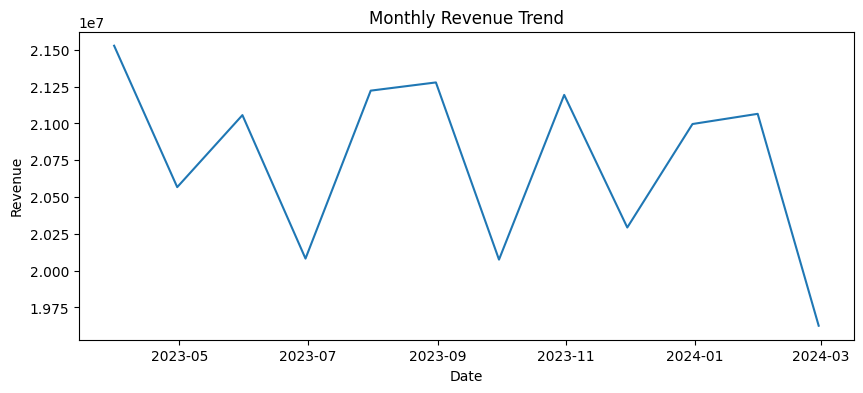

In [6]:
plt.figure(figsize=(10,4))
plt.plot(monthly_revenue)
plt.title("Monthly Revenue Trend")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.show()

Number of observations: 12
Not enough data for full seasonal decomposition (need 24+ months)
Using shorter period for trend analysis...


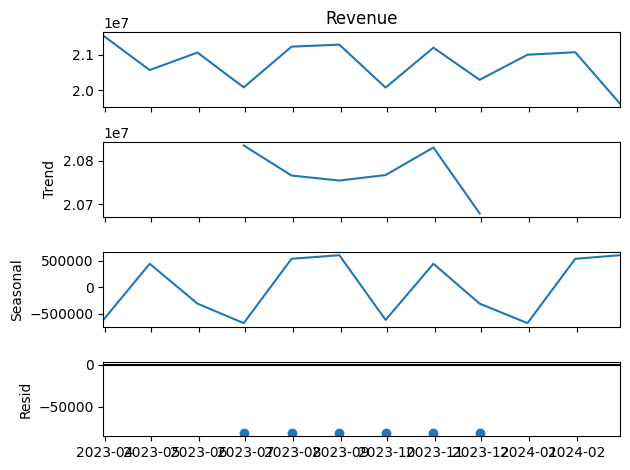

In [8]:
# Check if we have enough data for seasonal decomposition (need 2+ cycles)
print(f"Number of observations: {len(monthly_revenue)}")

if len(monthly_revenue) >= 24:
    # Full seasonal decomposition for monthly data
    decomposition = seasonal_decompose(monthly_revenue, model='additive', period=12)
    decomposition.plot()
    plt.show()
else:
    print("Not enough data for full seasonal decomposition (need 24+ months)")
    print("Using shorter period for trend analysis...")
    
    # Use a shorter period for decomposition
    if len(monthly_revenue) >= 12:
        decomposition = seasonal_decompose(monthly_revenue, model='additive', period=6)
        decomposition.plot()
        plt.show()
    else:
        print("Insufficient data for seasonal decomposition. Showing trend analysis only.")
        plt.figure(figsize=(12, 8))
        
        # Plot the data with rolling mean
        plt.subplot(2, 2, 1)
        plt.plot(monthly_revenue, label='Original')
        plt.plot(monthly_revenue.rolling(window=3).mean(), label='3-Month Moving Average')
        plt.title('Revenue with Trend')
        plt.legend()
        
        # Plot growth rate
        plt.subplot(2, 2, 2)
        growth_rate = monthly_revenue.pct_change() * 100
        plt.plot(growth_rate)
        plt.title('Month-over-Month Growth Rate (%)')
        
        # Plot cumulative revenue
        plt.subplot(2, 2, 3)
        plt.plot(monthly_revenue.cumsum())
        plt.title('Cumulative Revenue')
        
        # Basic statistics
        plt.subplot(2, 2, 4)
        stats_text = f"""
        Mean: ${monthly_revenue.mean():,.0f}
        Std: ${monthly_revenue.std():,.0f}
        Min: ${monthly_revenue.min():,.0f}
        Max: ${monthly_revenue.max():,.0f}
        """
        plt.text(0.1, 0.5, stats_text, fontsize=12, transform=plt.gca().transAxes)
        plt.axis('off')
        plt.title('Revenue Statistics')
        
        plt.tight_layout()
        plt.show()

In [9]:
model = ARIMA(monthly_revenue, order=(1,1,1))
model_fit = model.fit()

In [11]:
forecast_dates = pd.date_range(
    start=monthly_revenue.index[-1] + pd.offsets.MonthEnd(1),
    periods=6,
    freq='ME'
)

In [13]:
# Generate forecast for next 6 months
forecast = model_fit.forecast(steps=6)
forecast_conf_int = model_fit.get_forecast(steps=6).conf_int()

print("6-Month Revenue Forecast:")
for i, (date, pred) in enumerate(zip(forecast_dates, forecast)):
    print(f"{date.strftime('%Y-%m')}: ${pred:,.0f}")
    
print(f"\nTotal Forecasted Revenue (6 months): ${forecast.sum():,.0f}")
print(f"Average Monthly Forecast: ${forecast.mean():,.0f}")

6-Month Revenue Forecast:
2024-03: $19,684,776
2024-04: $19,652,630
2024-05: $19,670,153
2024-06: $19,660,601
2024-07: $19,665,808
2024-08: $19,662,970

Total Forecasted Revenue (6 months): $117,996,937
Average Monthly Forecast: $19,666,156


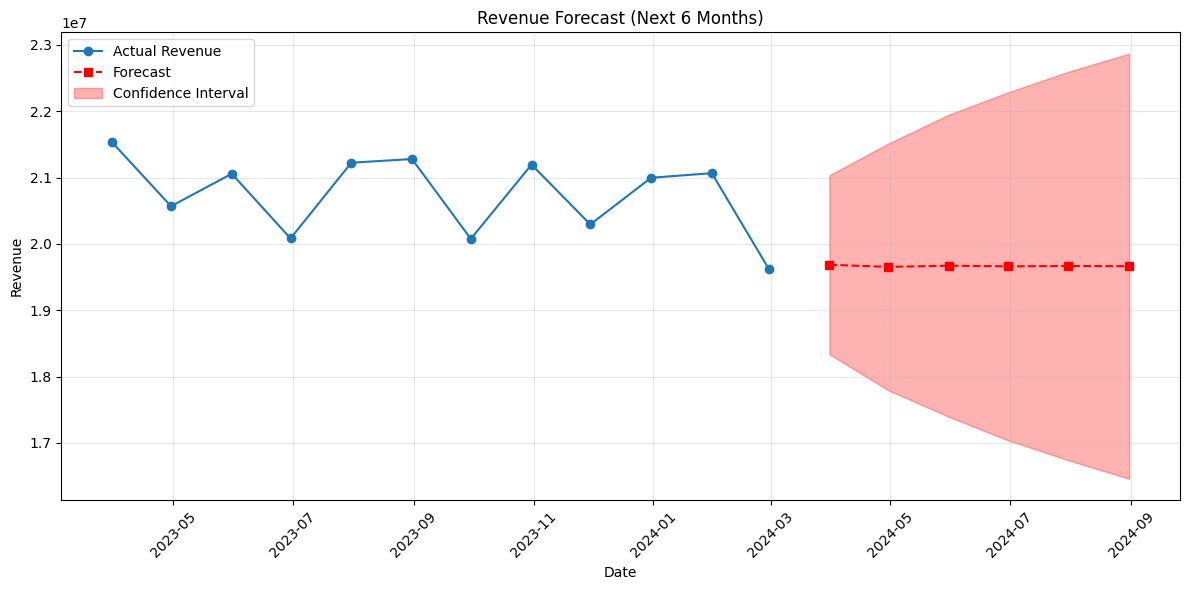


ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                   12
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -165.876
Date:                Thu, 29 Jan 2026   AIC                            337.752
Time:                        21:59:35   BIC                            338.945
Sample:                    03-31-2023   HQIC                           336.999
                         - 02-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5451      0.418     -1.305      0.192      -1.364       0.274
ma.L1          0.4923      0.472      1.043      0.297      -0.432       1.417
sigma2      4.742e+11   8.96e-

In [14]:
plt.figure(figsize=(12,6))

# Plot historical data
plt.plot(monthly_revenue.index, monthly_revenue, label='Actual Revenue', marker='o')

# Plot forecast
plt.plot(forecast_dates, forecast, label='Forecast', linestyle='--', marker='s', color='red')

# Plot confidence intervals
plt.fill_between(forecast_dates, 
                forecast_conf_int.iloc[:, 0], 
                forecast_conf_int.iloc[:, 1], 
                alpha=0.3, color='red', label='Confidence Interval')

plt.legend()
plt.title("Revenue Forecast (Next 6 Months)")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print model summary
print("\nARIMA Model Summary:")
print(model_fit.summary())

In [15]:
train = monthly_revenue[:-3]
test = monthly_revenue[-3:]

model = ARIMA(train, order=(1,1,1))
model_fit = model.fit()

predictions = model_fit.forecast(steps=3)

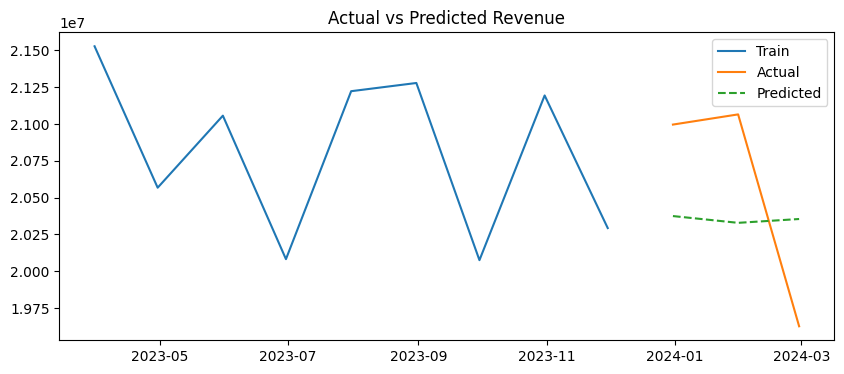

In [16]:
plt.figure(figsize=(10,4))
plt.plot(train, label='Train')
plt.plot(test, label='Actual')
plt.plot(test.index, predictions, label='Predicted', linestyle='--')
plt.legend()
plt.title("Actual vs Predicted Revenue")
plt.show()

In [17]:
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Forecasted_Revenue': forecast.values
})

forecast_df.to_csv("../outputs/revenue_forecast.csv", index=False)